# DCSI 592: Capstone II

## Predicting Crop Yield in Colorado: PreProcessing and EDA

Dataset: https://catalog.data.gov/dataset/usda-ars-colorado-maize-water-productivity-dataset-2012-2013-f9f68


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

FILE = '2012-2013_Maize_Compiled database 06012018.xlsx'
maize_excel_data = pd.ExcelFile(FILE)
maize_excel_data.sheet_names

['Data Dictionary',
 'Crop Log',
 'Annual data by plot',
 'Water Balance ET',
 'LAI by Plot',
 'Plant Ht by Plot',
 'Canopy Cover by Plot',
 'Soil Field Capacity',
 'Weather data']

## Helper functions

In [36]:
# generate distribution plots for all numeric columns (has KDE and uses seaborne)
def plot_distributions(dataframe, subject):
    numeric_cols = dataframe.select_dtypes(include=['float64', 'int64']).columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(5, 3, i)
        sns.histplot(dataframe[col].dropna() , kde=True)        # add stat='density' to normalize
        plt.title(f'{col}')
    plt.suptitle(f'Distribution for {subject} (Numeric) Variables', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# generate distribution comparison plots to compare transformation methods    
def plot_side_by_side_distributions(df1, df2, subject1, subject2):
    numeric_cols = df1.select_dtypes(include=['float64', 'int64']).columns

    plt.figure(figsize=(15, len(numeric_cols) * 2))
    
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols), 2, 2*i-1)
        sns.histplot(df1[col].dropna(), kde=True, stat='density', color='blue')
        plt.title(f'{subject1} - {col}')
        
        plt.subplot(len(numeric_cols), 2, 2*i)
        sns.histplot(df2[col].dropna(), kde=True, stat='density', color='orange')
        plt.title(f'{subject2} - {col}')

    plt.suptitle(f'Distribution Comparisons for {subject1} and {subject2} (Numeric) Variables', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()   

# get boxplot to see outliers for each numerical column in a df
def boxplot_numerical_columns(dataframe, figsize=(8, 5)):
    numerical_columns = dataframe.select_dtypes(include=['number']).columns
    num_cols = len(numerical_columns)
    num_rows = (num_cols + 3) // 4  # Calculate number of rows needed
    fig, axes = plt.subplots(num_rows, 4, figsize=figsize)
    for i, column in enumerate(numerical_columns):
        row = i // 4
        col = i % 4
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.boxplot(dataframe[column].dropna(), vert=False)
        ax.set_title(f'Boxplot of {column}')
        ax.set_xlabel('Value')
        ax.grid(True)
    # Remove empty subplots
    for i in range(num_cols, num_rows*4):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    plt.tight_layout()
    plt.show()
    
# get correlation heatmap
def heatmap(dataframe, figsize=(10, 8), cmap='coolwarm', annot=True, numeric_only=True):
    # Calculate correlation matrix
    corr = dataframe.corr(method='pearson', min_periods=1, numeric_only=True)
    # Set up the matplotlib figure
    plt.figure(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, annot=annot, fmt=".2f", vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    # Add title
    plt.title('Correlation Heatmap', fontsize=16)
    # Show plot
    plt.show()
    
# apply log transformation and add a constant to deal with 0s
def apply_log_transform_with_constant(dataframe, constant=1e-5):
    # Copy the input dataframe to avoid modifying the original data
    transformed_df = dataframe.copy()
        # Apply logarithmic transformation to numeric columns
    for col in transformed_df.select_dtypes(include=['number']).columns:
        # Add a small constant value to avoid zero values
        transformed_df[col] = np.log(transformed_df[col] + constant)
    return transformed_df

def return_normality_check_for_distributions(dataframe):
    numerical_columns = dataframe.select_dtypes(include=['number']).columns
    for col in numerical_columns:
        mean = dataframe[col].mean()
        std = dataframe[col].std()
        abs_z_score = dataframe[col].sub(mean).abs().div(std)
        pcts = [abs_z_score.lt(i).mean() for i in range(1,4)]
        print(f"FOR {col}:\n\t{pcts[0]:.4f} of values fall within 1 standard deviation, while {pcts[1]:.4f} fall within 2 standard deviations and {pcts[2]:.4f} within 3 standard deviations.")
    return

## Annual Data by Plot: Data Dictionary 
| **Annual Data by Plot** | **Description** |
|-------------------------|------------------|
| **Year**                | Year of measurement |
| **Plot**                | Plot codes; the letter refers to sections in an older structure of the field; sections A & B and C & D are now parts to the same field, respectively, with treatments randomized across these sections; Letter is the field section, first number is the block, second number combined with the letter designates one of 12 plots in each block |
| **Trt_code**            | The treatment code (1-12) assigned to each of the 12 treatments. See second table (below) |
| **Treatment**           | The treatment levels with the percent of full ET given in each of the two stress periods, the late vegetative and grain-filling periods, with the percent of full ET in late vegetative period given to the left of the slash and that of the grain-filling period to the right. |
| **HI kg/kg**            | Harvest index (kg/kg), unitless, calculated as grain dry mass divided by total shoot biomass dry mass, both with moisture content of the grain dried and adjusted to 0% |
| **TotShtBiom Kg ha-1**  | Total plant aboveground dry biomass (kg/ha) (seed moisture adjusted to 0%) |
| **Max_LAI**             | Leaf area index (cm^2 leaf area per cm^2 ground area), unitless; maximum value from four sampling dates taken over the season |
| **Plant density plants ha-1** | Plant density (plants/ha) at the end of the season |
| **Grain Yield_15.5%mc Kg ha-1** | Grain Yield (kg/ha) adjusted to 15.5% grain moisture |
| **Annual_ETc mm**       | Annual plot ET (mm) from planting through physiological maturity (R6 growth stage). (Consider this water usage) |
<!-- | **Growth_stage**        | Average growth stage of five plants per plot and four plots per treatment; growth stages were documented with standard notation of stages for maize (see Abendroth, L.J., Elmore, R.W., Boyer, M.J., Marlay, S.K. 2011. Corn growth and development. PMR 1009. Iowa State University Extension, Ames, Iowa.) | -->

<br>

| **Trt Code** | **Irr Treatment (late veg/grain filling)** |
|--------------|-------------------|
| 1            | 100/100           |
| 2            | 100/50            |
| 3            | 80/80             |
| 4            | 80/65             |
| 5            | 80/50             |
| 6            | 80/40             |
| 7            | 65/80             |
| 8            | 65/65             |
| 9            | 65/50             |
| 10           | 65/40             |
| 11           | 50/50             |
| 12           | 40/40             |


In [37]:
annual_data = pd.read_excel(FILE, sheet_name='Annual data by plot', header=1)
annual_data.shape

(96, 10)

In [38]:
annual_data.head()

,Year,Plot,Trt_code,Treatment,HI,TotShtBiom Kg ha-1,Max_LAI,Plant density plants ha-1,Grain Yield_15.5%mc_Kg ha-1,Annual_ETc mm
0,2012,B11,1,100/100,0.586753,27190.639617,4.435564,84388.982935,17057.151013,774.682512
1,2012,B23,1,100/100,0.588411,25044.635568,4.835313,79879.474986,17161.257063,778.938969
2,2012,A33,1,100/100,0.587896,21998.569708,4.311404,78074.161083,14265.067529,768.728947
3,2012,A42,1,100/100,0.578962,22473.576167,4.176203,77500.086369,14452.493033,760.781975
4,2012,A15,2,100/50,0.549887,20078.111899,5.191047,79838.205237,12444.753134,661.326236


In [39]:
annual_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         96 non-null     int64  
 1   Plot                         96 non-null     object 
 2   Trt_code                     96 non-null     int64  
 3   Treatment                    96 non-null     object 
 4   HI                           96 non-null     float64
 5   TotShtBiom Kg ha-1           96 non-null     object 
 6   Max_LAI                      96 non-null     float64
 7   Plant density plants ha-1    96 non-null     float64
 8   Grain Yield_15.5%mc_Kg ha-1  96 non-null     object 
 9   Annual_ETc mm                96 non-null     float64
dtypes: float64(4), int64(2), object(4)
memory usage: 7.6+ KB


In [40]:
annual_data.dtypes.value_counts()

object     4
float64    4
int64      2
Name: count, dtype: int64

The datatypes for Total shoot biomass (`TotShtBiom Kg ha-1`) and Grain Yield (`Grain Yield_15.5%mc_Kg ha-1`) are object types, which warrants a closer look. We use `.value_counts()` to look at the first 5 values. This reveals a character `.`, likely used as a NA or null entry, and the reason for the object datatype.

In [41]:
annual_data['TotShtBiom Kg ha-1'].value_counts()[:5]

TotShtBiom Kg ha-1
.               48
23031.329269     1
28589.606081     1
19352.157294     1
21581.924501     1
Name: count, dtype: int64

We examine these records and notice this value also shows up in the `Grain Yield` column, the other column with the suspect datatype. We also filter to these results. 

In [42]:
period_value_filter = annual_data['TotShtBiom Kg ha-1'] == '.'
annual_data[period_value_filter].head()

,Year,Plot,Trt_code,Treatment,HI,TotShtBiom Kg ha-1,Max_LAI,Plant density plants ha-1,Grain Yield_15.5%mc_Kg ha-1,Annual_ETc mm
48,2013,C12,1,100/100,0.539712,.,4.706015,78684.346217,16038.17839,671.729661
49,2013,C22,1,100/100,0.494684,.,4.606905,74663.978162,16062.967856,661.402184
50,2013,D31,1,100/100,0.514175,.,4.445525,68920.595227,.,657.000000
51,2013,D43,1,100/100,0.507232,.,4.356503,75238.316456,14997.055021,645.535935
52,2013,D12,2,100/50,0.516578,.,3.981743,75812.654750,11979.196623,560.522365


In [43]:
period_value_filter2 = annual_data['Grain Yield_15.5%mc_Kg ha-1'] == '.'
annual_data[period_value_filter2]

,Year,Plot,Trt_code,Treatment,HI,TotShtBiom Kg ha-1,Max_LAI,Plant density plants ha-1,Grain Yield_15.5%mc_Kg ha-1,Annual_ETc mm
50,2013,D31,1,100/100,0.514175,.,4.445525,68920.595227,.,657.000000
95,2013,C46,12,40/40,0.520715,.,3.460072,78110.007924,.,423.764911


We replace the `.` chars with numpy's "Not a Number" value to represent the missing values and confirm this resolves the datatype error.

In [44]:
annual_data.replace('.', np.nan, inplace=True)
annual_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         96 non-null     int64  
 1   Plot                         96 non-null     object 
 2   Trt_code                     96 non-null     int64  
 3   Treatment                    96 non-null     object 
 4   HI                           96 non-null     float64
 5   TotShtBiom Kg ha-1           48 non-null     float64
 6   Max_LAI                      96 non-null     float64
 7   Plant density plants ha-1    96 non-null     float64
 8   Grain Yield_15.5%mc_Kg ha-1  94 non-null     float64
 9   Annual_ETc mm                96 non-null     float64
dtypes: float64(6), int64(2), object(2)
memory usage: 7.6+ KB


C:\Users\klfox\AppData\Local\Temp\ipykernel_24964\3056153685.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annual_data.replace('.', np.nan, inplace=True)


Now we can investigate null counts.

In [45]:
annual_data.isnull().sum()

Year                            0
Plot                            0
Trt_code                        0
Treatment                       0
HI                              0
TotShtBiom Kg ha-1             48
Max_LAI                         0
Plant density plants ha-1       0
Grain Yield_15.5%mc_Kg ha-1     2
Annual_ETc mm                   0
dtype: int64

In [46]:
annual_data.isnull().sum().sum()

50

In [47]:
annual_data = annual_data.dropna(subset = 'Grain Yield_15.5%mc_Kg ha-1')

In [48]:
annual_data.isnull().sum()

Year                            0
Plot                            0
Trt_code                        0
Treatment                       0
HI                              0
TotShtBiom Kg ha-1             46
Max_LAI                         0
Plant density plants ha-1       0
Grain Yield_15.5%mc_Kg ha-1     0
Annual_ETc mm                   0
dtype: int64

### Descriptive Statistics

In [49]:
annual_data.describe()

,Year,Trt_code,HI,TotShtBiom Kg ha-1,Max_LAI,Plant density plants ha-1,Grain Yield_15.5%mc_Kg ha-1,Annual_ETc mm
count,94.000000,94.000000,94.000000,48.000000,94.000000,94.000000,94.000000,94.000000
mean,2012.489362,6.500000,0.547216,20354.726136,4.392121,79216.983828,12894.174105,562.777579
std,0.502567,3.413288,0.034370,3466.688393,0.366701,3815.700877,2036.476397,79.232730
min,2012.000000,1.000000,0.482495,14024.642492,3.669094,71284.111818,8106.485167,415.914911
25%,2012.000000,4.000000,0.520488,17833.854402,4.142939,76394.386750,11521.358935,501.380634
50%,2012.000000,6.500000,0.549759,20137.919386,4.357404,78779.658703,12838.394823,562.651667
75%,2013.000000,9.000000,0.572509,22496.424482,4.607892,81412.453112,14520.297157,599.947717
max,2013.000000,12.000000,0.616426,28589.606081,5.438417,91103.161110,17161.257063,778.938969


The Treatment column is the only string, or object, type, and it's also represented by the Trt_code column. We can drop the `Treatment` column.

In [50]:
annual_data.describe(include=['object'])

,Plot,Treatment
count,94,94
unique,94,12
top,B11,100/50
freq,1,8


In [51]:
# checking number of water treatments --  was equal before we dropped the two null grain yield records (affects treatment 1 and 12)
annual_data["Trt_code"].value_counts()

Trt_code
2     8
3     8
4     8
5     8
6     8
7     8
8     8
9     8
10    8
11    8
1     7
12    7
Name: count, dtype: int64

### About the water treatments
From: https://doi.org/10.1016/j.agwat.2018.07.015

<img src="water_treatment_fig_AB.jpg" alt="Figure 1. ET water treatment combinations" width="500">

"Fig. 1. Schematics of the evapotranspiration (ET) targets for treatment combinations. 
Water deficits were targeted during two periods of development, the **late vegetative** and **maturation/grain-filling** periods (A). Percentages of ET targeted during each of these periods (separated by a ‘/’) were established to test effects of unequal compared to equal ET during stress periods (B).

Five treatments applied equal amounts of ET during the late vegetative and maturation periods (i.e. 100/100, 80/80, 65/65, 50/50, 40/40). 
Seven treatments varied in amount of ET supplied between these periods (e.g. 65/40). 
Only one treatment had less deficit targeted during the maturation period than during the vegetative (65/80). 
All treatments were given full irrigation during sensitive early vegetative (emergence-V7) and reproductive periods (i.e. VT-R3)."

<img src="highlighting_highest_grainyield.png" alt="highlighting treatements with highest grain yields" width="500">

Which watering treatments had the greatest grain yield? (Highlighted in above figure)
<br>`1 = (100/100)` 
<br>`3 = (80/80)`
<br>`7 = (65/80)`
<br>`4 = (80/65)`
<br>`8 = (65/65)`

In [52]:
treatment_aggregation = annual_data.groupby("Trt_code").agg({
    "Grain Yield_15.5%mc_Kg ha-1" : "mean",
    "Max_LAI" : "mean",
    "Plant density plants ha-1" : "mean",
    "Annual_ETc mm" : "mean",
    "HI": "mean"
})

treatment_aggregation.sort_values(by='Grain Yield_15.5%mc_Kg ha-1', ascending=False).head()

,Grain Yield_15.5%mc_Kg ha-1,Max_LAI,Plant density plants ha-1,Annual_ETc mm,HI
Trt_code,,,,,
1,15719.167129,4.489701,78347.049458,723.114312,0.554807
3,15123.518282,4.568961,79894.735445,628.298045,0.560953
7,14905.323786,4.449378,80661.581559,599.712516,0.573962
4,14090.194463,4.441064,78877.370130,588.208271,0.542170
8,13259.174077,4.224053,79671.350073,553.162660,0.564762


<!-- | **Trt Code** | **Irr Treatment (late veg/grain filling)** |
|--------------|-------------------|
| 1            | 100/100           |
| 2            | 100/50            |
| 3            | 80/80             |
| 4            | 80/65             |
| 5            | 80/50             |
| 6            | 80/40             |
| 7            | 65/80             |
| 8            | 65/65             |
| 9            | 65/50             |
| 10           | 65/40             |
| 11           | 50/50             |
| 12           | 40/40             | -->

<img src="highlighting_lowest_grain_yield.png" alt="highlighting treatements with lowest grain yields" width="500">

Which watering treatments had the least grain yield? (Highlighted in above figure)
<br>`12 = (40/40)` 
<br>`10 = (65/40)`
<br>`6 = (80/40)`
<br>`11 = (50/50)`
<br>`9 = (65/50)`

In [53]:
treatment_aggregation.sort_values(by='Grain Yield_15.5%mc_Kg ha-1', ascending=True).head()

,Grain Yield_15.5%mc_Kg ha-1,Max_LAI,Plant density plants ha-1,Annual_ETc mm,HI
Trt_code,,,,,
12,9777.680115,4.193637,79234.275367,453.028315,0.544272
10,11270.585439,4.517898,78522.245169,497.550654,0.530549
6,11703.606684,4.483323,80819.333478,546.888956,0.536200
11,11719.826426,4.183556,80199.300448,492.416091,0.558170
9,12079.357173,4.368226,79121.150299,522.450649,0.541309


Which watering treatments had the greatest leaf area index?
<br>`3 = (80/80)`
<br>`10 = (65/40)`
<br>`2 = (100/50)`
<br>`1 = (100/100)` 
<br>`6 = (80/40)`

In [54]:
treatment_aggregation.sort_values(by='Max_LAI', ascending=False).head()

,Grain Yield_15.5%mc_Kg ha-1,Max_LAI,Plant density plants ha-1,Annual_ETc mm,HI
Trt_code,,,,,
3,15123.518282,4.568961,79894.735445,628.298045,0.560953
10,11270.585439,4.517898,78522.245169,497.550654,0.530549
2,12874.863012,4.493008,78125.456244,609.170416,0.527376
1,15719.167129,4.489701,78347.049458,723.114312,0.554807
6,11703.606684,4.483323,80819.333478,546.888956,0.536200


In [55]:
# sorting water treatments by annual evapotranspiration (water usage)
treatment_aggregation.sort_values(by='Annual_ETc mm', ascending=False).head()

,Grain Yield_15.5%mc_Kg ha-1,Max_LAI,Plant density plants ha-1,Annual_ETc mm,HI
Trt_code,,,,,
1,15719.167129,4.489701,78347.049458,723.114312,0.554807
3,15123.518282,4.568961,79894.735445,628.298045,0.560953
2,12874.863012,4.493008,78125.456244,609.170416,0.527376
7,14905.323786,4.449378,80661.581559,599.712516,0.573962
4,14090.194463,4.441064,78877.370130,588.208271,0.542170


In [56]:
annual_numeric = annual_data.select_dtypes(include=['number'])
annual_numeric

,Year,Trt_code,HI,TotShtBiom Kg ha-1,Max_LAI,Plant density plants ha-1,Grain Yield_15.5%mc_Kg ha-1,Annual_ETc mm
0,2012,1,0.586753,27190.639617,4.435564,84388.982935,17057.151013,774.682512
1,2012,1,0.588411,25044.635568,4.835313,79879.474986,17161.257063,778.938969
2,2012,1,0.587896,21998.569708,4.311404,78074.161083,14265.067529,768.728947
3,2012,1,0.578962,22473.576167,4.176203,77500.086369,14452.493033,760.781975
4,2012,2,0.549887,20078.111899,5.191047,79838.205237,12444.753134,661.326236
...,...,...,...,...,...,...,...,...
90,2013,11,0.549812,NaN,3.997997,75812.654750,11837.767850,452.959968
91,2013,11,0.528653,NaN,4.318541,76961.331337,12792.211174,447.664341
92,2013,12,0.521758,NaN,3.910411,76386.993043,8297.308445,415.914911
93,2013,12,0.485642,NaN,4.639491,75812.654750,8106.485167,420.864911


## DISTRIBUTIONS

We are not interested in the distributions for the treatments and the years, since these are known and controlled features (12 treatments, evenly applied)

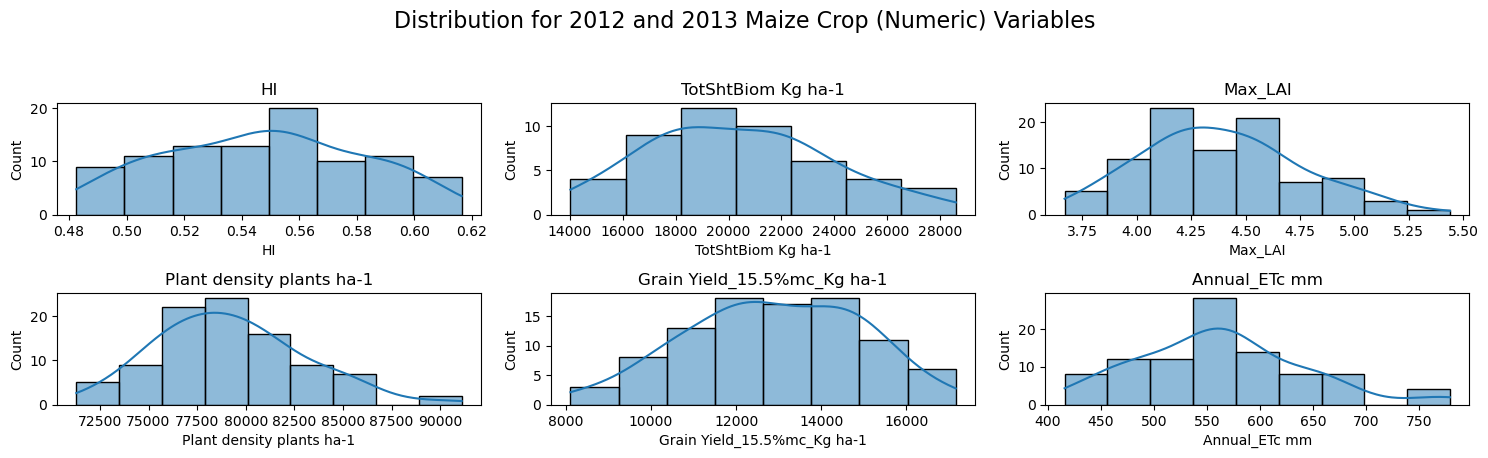

In [57]:
# Since we know there 12 treatments and two years of growth, we can leave these out of our distribution analysis
target_cols = ["HI", "TotShtBiom Kg ha-1", "Max_LAI", "Plant density plants ha-1", "Grain Yield_15.5%mc_Kg ha-1", "Annual_ETc mm"]
annual_numeric_dist = annual_numeric[target_cols]

plot_distributions(dataframe=annual_numeric_dist, subject="2012 and 2013 Maize Crop")

Most features show symmetrical distributions in both histograms and box plots, which indicates normality. We do observe slight skewness in `Annual_ETc` (Evaportranspiration) for both the histrogram and the box and whisker plot. `Plant density` and `Annual ETc` also have minor outliers 
Skewness: `Annual ETc` shows a slight right skew in both plots.
Outliers: Minor outliers are observed in `Plant Density` and `Annual ETc`. `Max_LAI` also has one outlier.

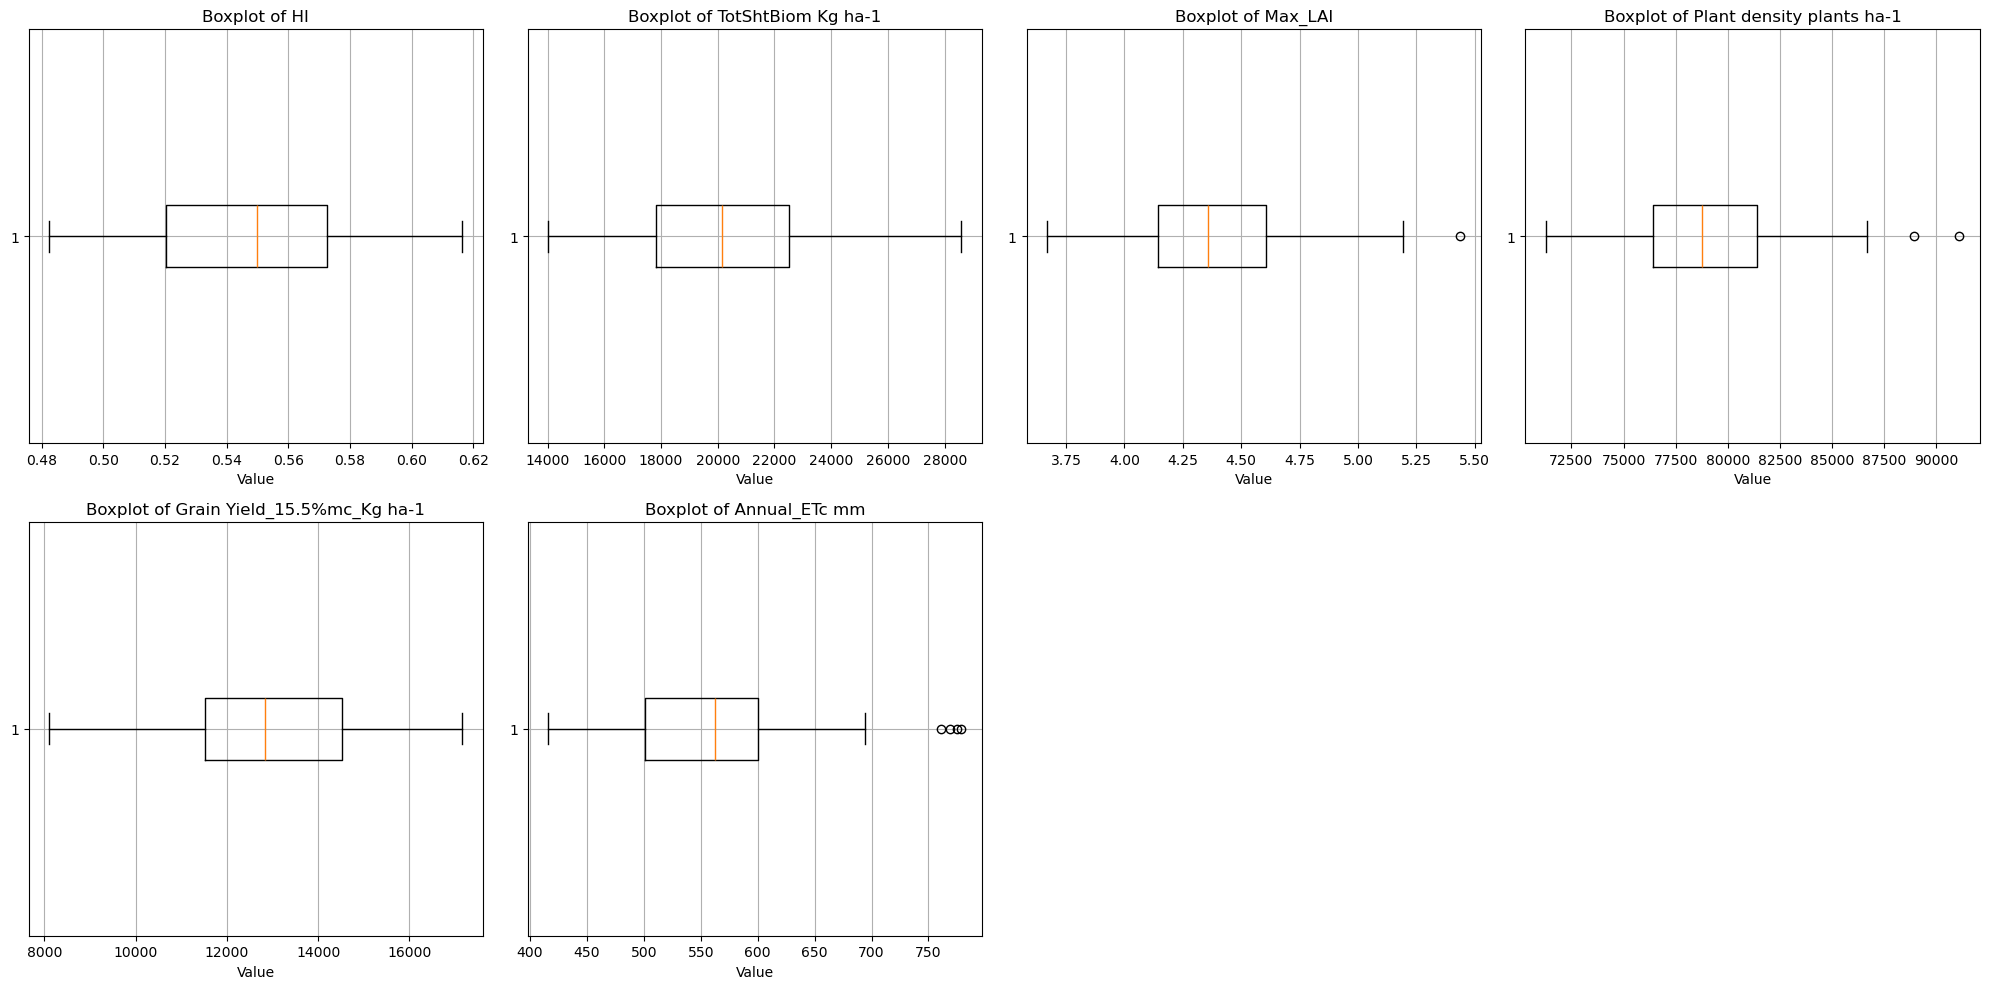

In [58]:
boxplot_numerical_columns(dataframe=annual_numeric_dist, figsize=(20,10))

**Skewness** measures the asymmetry of the data distribution.<br>
- Positive: The distribution has a longer tail on the right side (more high values).<br>
- Negative: The distribution has a longer tail on the left side (more low values).<br>
- Close to 0: The distribution is fairly symmetrical.<br>

**Kurtosis** measures the "tailedness" of the distribution.<br>
- Positive: heavier tails (more extreme values) and sharper peak than that of a normal dist.<br>
- Negative: lighter tails (fewer extreme values) and flatter peak than that of a normal dist.<br>

The results show that most features show slight to moderate skewness, with `Grain Yield_15.5%mc_Kg ha-1` having a slight negative skew while the others have a positive skew.
The kurtosis values suggest that most of the distributions are close to normal with slight deviations: either flatter (`HI`, `TotShtBiom`, `Grain Yield`, as seen in the KDE for the histogram plots) or with heavier tails (`Max_LAI`, `Plant Density`, `Annual_ETc`).

In [59]:
def kurtosis_and_skew_check_for_distributions(dataframe):
    numerical_columns = dataframe.select_dtypes(include=['number']).columns
    for col in numerical_columns:
        skewness = dataframe[col].skew()
        kurtosis = dataframe[col].kurt()
        print(f"For {col}:\n\tSkewness: {skewness:.3f}\n\tKurtosis: {kurtosis:.3f}")
    return

kurtosis_and_skew_check_for_distributions(annual_numeric_dist)

For HI:
	Skewness: 0.009
	Kurtosis: -0.912
For TotShtBiom Kg ha-1:
	Skewness: 0.303
	Kurtosis: -0.390
For Max_LAI:
	Skewness: 0.374
	Kurtosis: -0.125
For Plant density plants ha-1:
	Skewness: 0.494
	Kurtosis: 0.254
For Grain Yield_15.5%mc_Kg ha-1:
	Skewness: -0.151
	Kurtosis: -0.560
For Annual_ETc mm:
	Skewness: 0.543
	Kurtosis: 0.379


**68-95-99.7 RULE FOR DISTRIBUTIONS**

Normal distributions follow the 68-95-99.7 rule, where 68% of values fall within 1 std deviation, 95% fall within 2, and 99.7 fall within 3 std deviations. 

In [60]:
return_normality_check_for_distributions(annual_numeric_dist)

FOR HI:
	0.6064 of values fall within 1 standard deviation, while 0.9894 fall within 2 standard deviations and 1.0000 within 3 standard deviations.
FOR TotShtBiom Kg ha-1:
	0.3511 of values fall within 1 standard deviation, while 0.5000 fall within 2 standard deviations and 0.5106 within 3 standard deviations.
FOR Max_LAI:
	0.6702 of values fall within 1 standard deviation, while 0.9681 fall within 2 standard deviations and 1.0000 within 3 standard deviations.
FOR Plant density plants ha-1:
	0.6915 of values fall within 1 standard deviation, while 0.9681 fall within 2 standard deviations and 0.9894 within 3 standard deviations.
FOR Grain Yield_15.5%mc_Kg ha-1:
	0.6277 of values fall within 1 standard deviation, while 0.9574 fall within 2 standard deviations and 1.0000 within 3 standard deviations.
FOR Annual_ETc mm:
	0.6702 of values fall within 1 standard deviation, while 0.9574 fall within 2 standard deviations and 1.0000 within 3 standard deviations.


## TRANSFORMATIONS 

We will try a few methods to transform the data to normalize the distributions. We can use each to see how it affects our model. We'll start with a log transformation. We are looking into other methods used for slight skew to see if this will give us better results. The comparison plots show that the log transformation to `TotShtBiom Kg ha-1`, `Grain Yield_15.5%mc_Kg ha-1`, `Annual_ETc mm` slightly improves symmetry and normality. We will also do some comparison box and whisker plots.

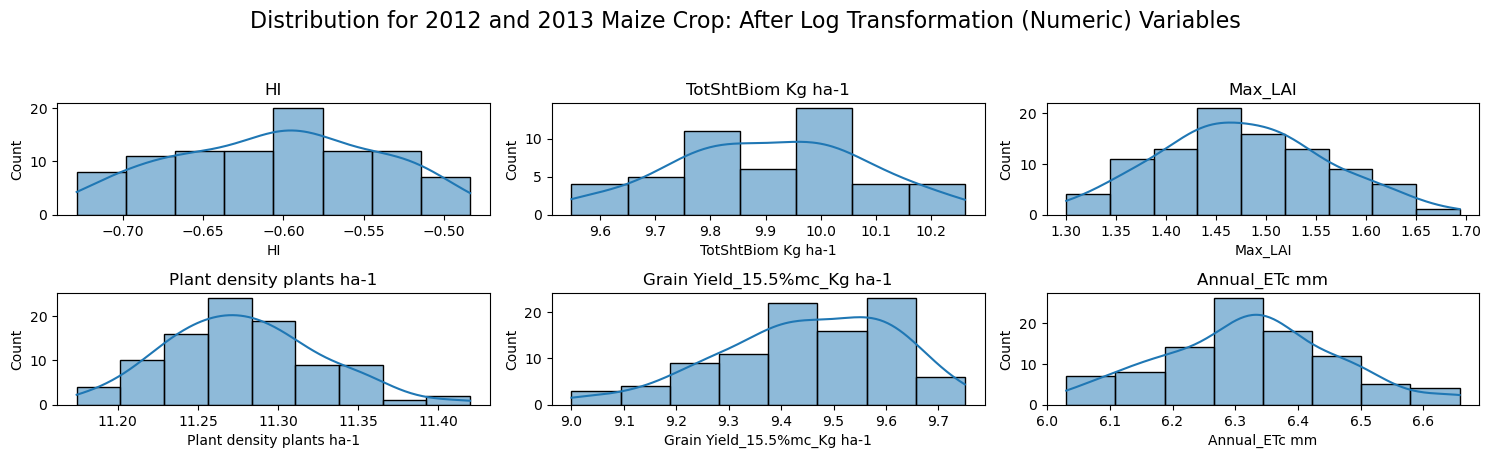

In [61]:
from scipy import stats
log_transformed_annual_numeric = apply_log_transform_with_constant(dataframe=annual_numeric_dist)

plot_distributions(dataframe=log_transformed_annual_numeric, subject="2012 and 2013 Maize Crop: After Log Transformation")

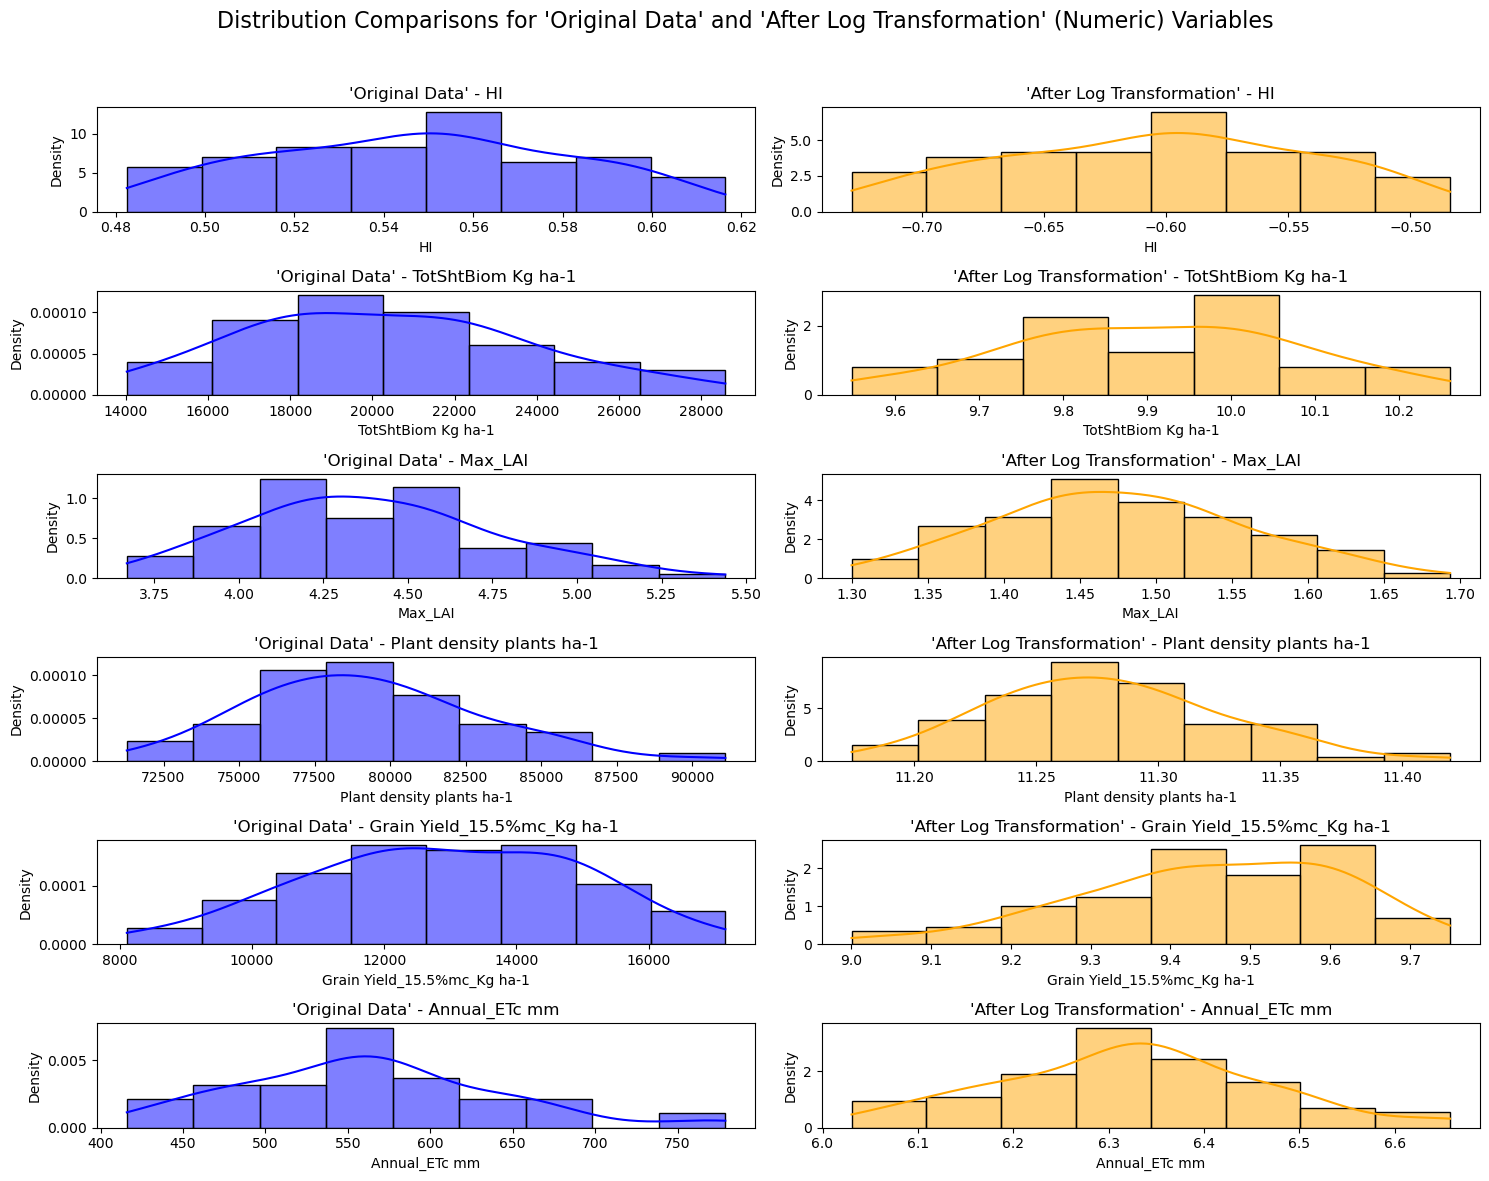

In [62]:
plot_side_by_side_distributions(df1=annual_numeric_dist, df2=log_transformed_annual_numeric, subject1="'Original Data'", subject2="'After Log Transformation'")

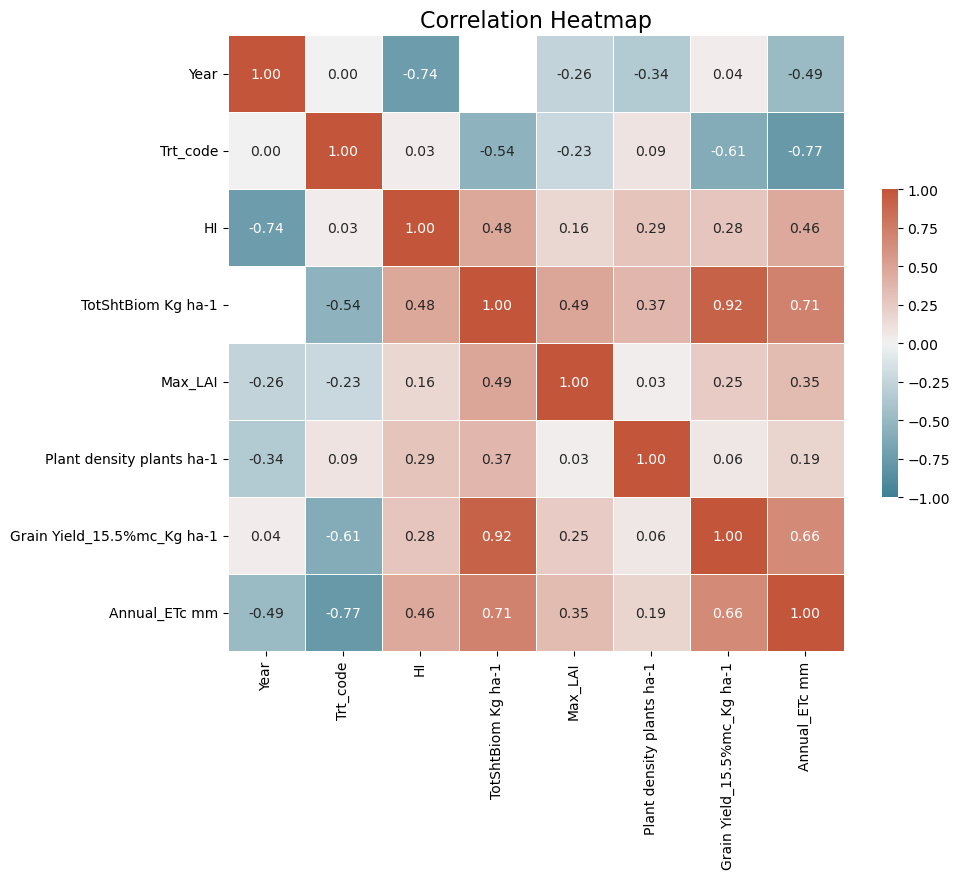

In [63]:
heatmap(dataframe=annual_numeric, figsize=(10, 8), cmap='coolwarm', annot=True)

In [64]:
# same results as above, but focused on target feature
annual_corr = annual_numeric.corr()
annual_corr['Grain Yield_15.5%mc_Kg ha-1'].sort_values(ascending=False)

Grain Yield_15.5%mc_Kg ha-1    1.000000
TotShtBiom Kg ha-1             0.916004
Annual_ETc mm                  0.658310
HI                             0.284433
Max_LAI                        0.247944
Plant density plants ha-1      0.063134
Year                           0.037497
Trt_code                      -0.607246
Name: Grain Yield_15.5%mc_Kg ha-1, dtype: float64

array([[<Axes: xlabel='Year', ylabel='Year'>,
        <Axes: xlabel='Trt_code', ylabel='Year'>,
        <Axes: xlabel='HI', ylabel='Year'>,
        <Axes: xlabel='TotShtBiom Kg ha-1', ylabel='Year'>,
        <Axes: xlabel='Max_LAI', ylabel='Year'>,
        <Axes: xlabel='Plant density plants ha-1', ylabel='Year'>,
        <Axes: xlabel='Grain Yield_15.5%mc_Kg ha-1', ylabel='Year'>,
        <Axes: xlabel='Annual_ETc mm', ylabel='Year'>],
       [<Axes: xlabel='Year', ylabel='Trt_code'>,
        <Axes: xlabel='Trt_code', ylabel='Trt_code'>,
        <Axes: xlabel='HI', ylabel='Trt_code'>,
        <Axes: xlabel='TotShtBiom Kg ha-1', ylabel='Trt_code'>,
        <Axes: xlabel='Max_LAI', ylabel='Trt_code'>,
        <Axes: xlabel='Plant density plants ha-1', ylabel='Trt_code'>,
        <Axes: xlabel='Grain Yield_15.5%mc_Kg ha-1', ylabel='Trt_code'>,
        <Axes: xlabel='Annual_ETc mm', ylabel='Trt_code'>],
       [<Axes: xlabel='Year', ylabel='HI'>,
        <Axes: xlabel='Trt_code', ylabel='

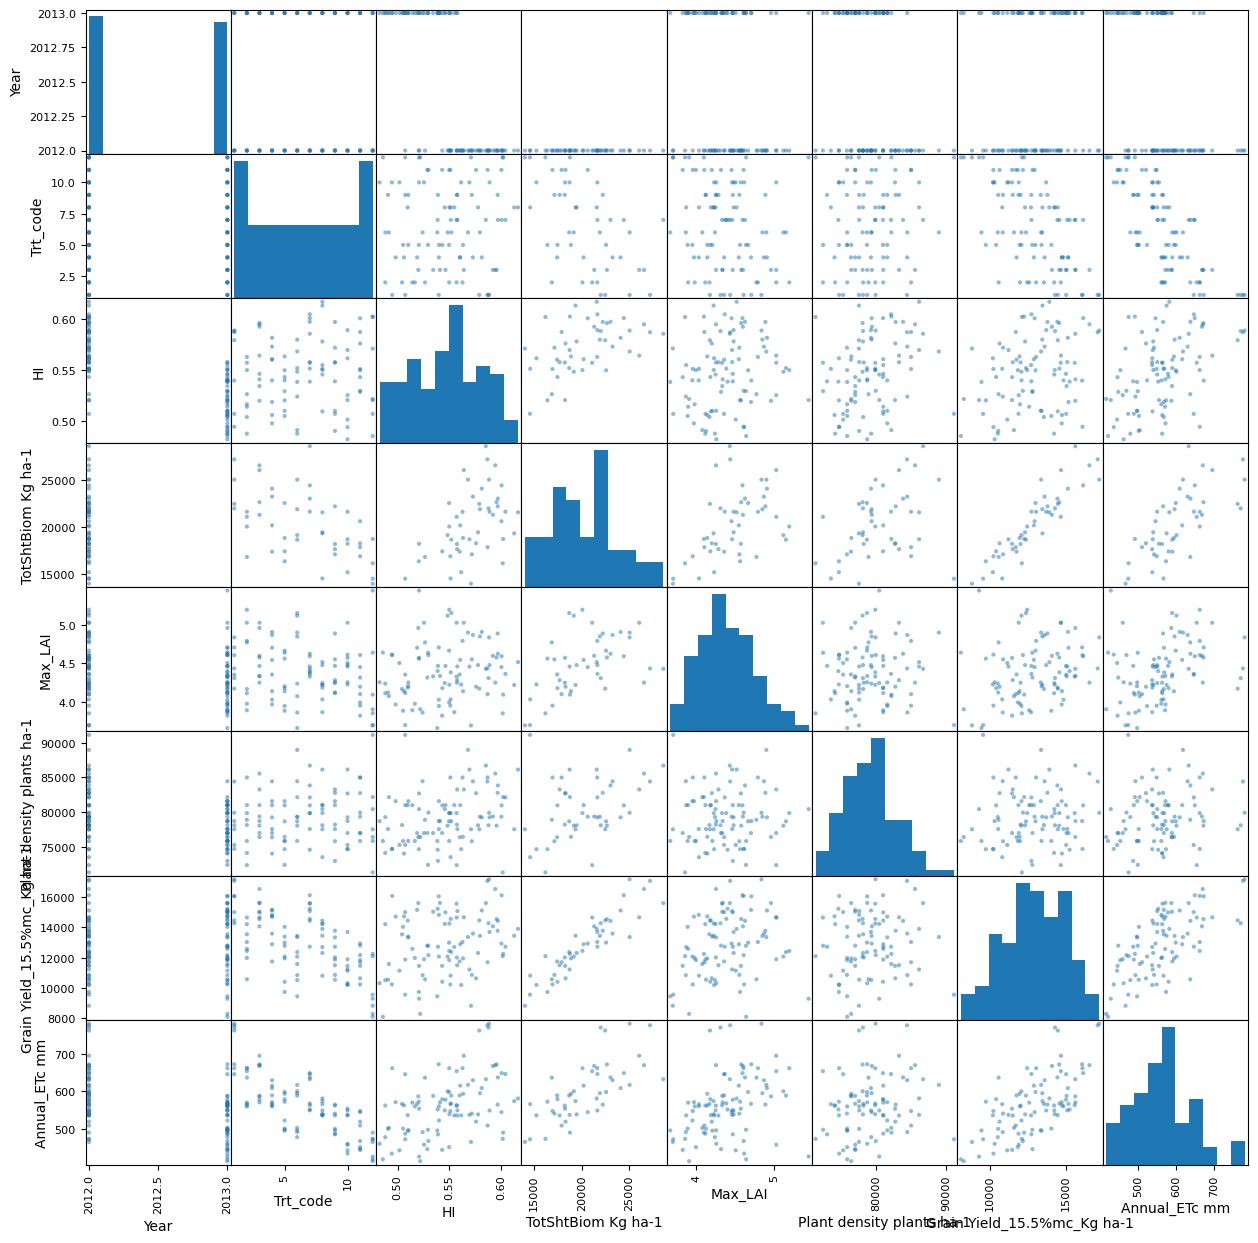

In [65]:
pd.plotting.scatter_matrix(frame=annual_numeric, figsize=(15,15))

| **Variable and units** | **Description** |
|-------------------------|------------------|
| **HI kg/kg**            | Harvest index (kg/kg), unitless, calculated as grain dry mass divided by total shoot biomass dry mass, both with moisture content of the grain dried and adjusted to 0% |
| **TotShtBiom Kg ha-1**  | Total plant aboveground dry biomass (kg/ha) (seed moisture adjusted to 0%) |
| **Grain Yield_15.5%mc Kg ha-1** | Grain Yield (kg/ha) adjusted to 15.5% grain moisture |

Harvest Index (HI) is calculated as $ \frac{\text{Grain Yield}}{\text{Total Shoot Biomass}} $. 

It is used to measure a crop's efficiency because it measures how much biomass was converted into grain (corn kernels). 

Total shoot biomass includes the stalk, leaves, ears of corn, the corn husks, and the grain (i.e., everything above soil).


In [66]:
annual_numeric.to_csv('cleaned_annual_data.csv', index=False)

## Descriptive Statistics

In [67]:
annual_numeric.describe()

,Year,Trt_code,HI,TotShtBiom Kg ha-1,Max_LAI,Plant density plants ha-1,Grain Yield_15.5%mc_Kg ha-1,Annual_ETc mm
count,94.000000,94.000000,94.000000,48.000000,94.000000,94.000000,94.000000,94.000000
mean,2012.489362,6.500000,0.547216,20354.726136,4.392121,79216.983828,12894.174105,562.777579
std,0.502567,3.413288,0.034370,3466.688393,0.366701,3815.700877,2036.476397,79.232730
min,2012.000000,1.000000,0.482495,14024.642492,3.669094,71284.111818,8106.485167,415.914911
25%,2012.000000,4.000000,0.520488,17833.854402,4.142939,76394.386750,11521.358935,501.380634
50%,2012.000000,6.500000,0.549759,20137.919386,4.357404,78779.658703,12838.394823,562.651667
75%,2013.000000,9.000000,0.572509,22496.424482,4.607892,81412.453112,14520.297157,599.947717
max,2013.000000,12.000000,0.616426,28589.606081,5.438417,91103.161110,17161.257063,778.938969


We are not planning to use total shoot biomass `TotShtBiom Kg ha-1` in our model, due to its high correlation `.92`, so we did not remove the null values. 

In [68]:
annual_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 0 to 94
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         94 non-null     int64  
 1   Trt_code                     94 non-null     int64  
 2   HI                           94 non-null     float64
 3   TotShtBiom Kg ha-1           48 non-null     float64
 4   Max_LAI                      94 non-null     float64
 5   Plant density plants ha-1    94 non-null     float64
 6   Grain Yield_15.5%mc_Kg ha-1  94 non-null     float64
 7   Annual_ETc mm                94 non-null     float64
dtypes: float64(6), int64(2)
memory usage: 6.6 KB


## Next Steps
- find and apply other transformation methods for slight skew to compare against log transformations & no transformations
- comparison box and whisker plots for above
- implement regression models 
- experiment with hyperparameter tuning
- if there's time, look at the weather data for each year